# INM706 Coursework
## Disease Prognosis Prediction using Longitudinal Electronic Health Records and Gated Recurrent Units
### Aaron Mir (Student Number: 160001207)

MIMIC-III is a large, freely-available database comprising deidentified health-related data associated with over 40,000 patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The MIMIC-III Clinical Database is available on PhysioNet (doi: 10.13026/C2XW26). Though deidentified, MIMIC-III contains detailed information regarding the care of real patients, and as such requires credentialing before access. To allow researchers to ascertain whether the database is suitable for their work, we have manually curated a demo subset, which contains information for 100 patients also present in the MIMIC-III Clinical Database. Notably, the demo dataset does not include free-text notes.

The demo dataset contains all intensive care unit (ICU) stays for 100 patients. These patients were selected randomly from the subset of patients in the dataset who eventually die. Consequently, all patients will have a date of death (DOD). However, patients do not necessarily die during an individual hospital admission or ICU stay.

Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID.
Each row of this table contains a unique HADM_ID, which represents a single patient’s admission to the hospital. HADM_ID ranges from 1000000 - 1999999. It is possible for this table to have duplicate SUBJECT_ID, indicating that a single patient had multiple admissions to the hospital. The ADMISSIONS table can be linked to the PATIENTS table using SUBJECT_ID.
https://mimic.physionet.org/mimictables/admissions/ - info about admissions table

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

## Exploratory Analysis of Data
### Admissions Table

In [11]:
admission_data = pd.read_csv('data\\ADMISSIONS.csv')

In [42]:
admission_data.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,next_admittime,next_admission_type,days_next_admit
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1,NaT,NaN,NaN
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,...,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1,NaT,NaN,NaN
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1,NaT,NaN,NaN
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1,NaT,NaN,NaN
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1,NaT,NaN,NaN


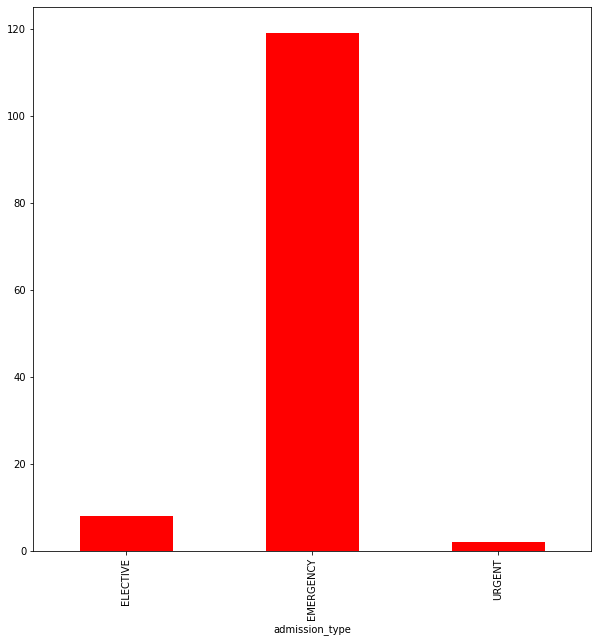

In [14]:
fig = plt.figure(figsize=(10,10))
admission_data.groupby(['admission_type']).size().plot.bar(color = 'red');

In [15]:
admission_data.admittime = pd.to_datetime(admission_data.admittime, format = '%Y-%m-%d %H:%M:%S')
admission_data.dischtime = pd.to_datetime(admission_data.dischtime, format = '%Y-%m-%d %H:%M:%S')
admission_data.deathtime = pd.to_datetime(admission_data.deathtime, format = '%Y-%m-%d %H:%M:%S')

In [16]:
admission_data = admission_data.sort_values(['subject_id','admittime'])
admission_data = admission_data.reset_index(drop = True)

In [23]:
admission_data.loc[admission_data.subject_id == 44083, ['subject_id','admittime','admission_type']]

,subject_id,admittime,admission_type
122,44083,2112-05-04 08:00:00,ELECTIVE
123,44083,2112-05-22 15:37:00,EMERGENCY
124,44083,2112-05-28 15:45:00,EMERGENCY


In [27]:
admission_data['next_admittime'] = admission_data.groupby('subject_id').admittime.shift(-1)
admission_data['next_admission_type'] = admission_data.groupby('subject_id').admission_type.shift(-1)

In [29]:
admission_data.loc[admission_data.subject_id == 44083,['subject_id','admittime','admission_type','next_admittime','next_admission_type']]

,subject_id,admittime,admission_type,next_admittime,next_admission_type
122,44083,2112-05-04 08:00:00,ELECTIVE,2112-05-22 15:37:00,EMERGENCY
123,44083,2112-05-22 15:37:00,EMERGENCY,2112-05-28 15:45:00,EMERGENCY
124,44083,2112-05-28 15:45:00,EMERGENCY,NaT,NaN


In [32]:
rows = admission_data.next_admission_type == 'ELECTIVE'
admission_data.loc[rows,'next_admittime'] = pd.NaT
admission_data.loc[rows,'next_admission_type'] = np.NaN

In [33]:
admission_data.loc[admission_data.subject_id == 44083,['subject_id','admittime','admission_type','next_admittime','next_admission_type']]

,subject_id,admittime,admission_type,next_admittime,next_admission_type
122,44083,2112-05-04 08:00:00,ELECTIVE,2112-05-22 15:37:00,EMERGENCY
123,44083,2112-05-22 15:37:00,EMERGENCY,2112-05-28 15:45:00,EMERGENCY
124,44083,2112-05-28 15:45:00,EMERGENCY,NaT,NaN


In [34]:
admission_data = admission_data.sort_values(['subject_id','admittime'])

In [35]:
admission_data.loc[admission_data.subject_id == 44083,['subject_id','admittime','admission_type','next_admittime','next_admission_type']]

,subject_id,admittime,admission_type,next_admittime,next_admission_type
122,44083,2112-05-04 08:00:00,ELECTIVE,2112-05-22 15:37:00,EMERGENCY
123,44083,2112-05-22 15:37:00,EMERGENCY,2112-05-28 15:45:00,EMERGENCY
124,44083,2112-05-28 15:45:00,EMERGENCY,NaT,NaN


In [37]:
admission_data[['next_admittime','next_admission_type']] = admission_data.groupby(['subject_id'])\
[['next_admittime','next_admission_type']].fillna(method = 'bfill')

In [38]:
admission_data.loc[admission_data.subject_id == 44083,['subject_id','admittime','admission_type','next_admittime','next_admission_type']]

,subject_id,admittime,admission_type,next_admittime,next_admission_type
122,44083,2112-05-04 08:00:00,ELECTIVE,2112-05-22 15:37:00,EMERGENCY
123,44083,2112-05-22 15:37:00,EMERGENCY,2112-05-28 15:45:00,EMERGENCY
124,44083,2112-05-28 15:45:00,EMERGENCY,NaT,NaN


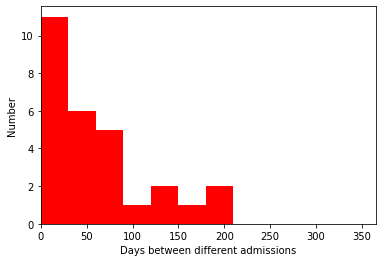

In [59]:
fig = plt.figure() 
admission_data['days_next_admit'] = (admission_data.next_admittime - admission_data.dischtime).dt.total_seconds()/(24*60*60)
plt.hist(admission_data.loc[~admission_data.days_next_admit.isnull(),'days_next_admit'], bins = range(0,365,30), color = 'red')
plt.xlim([0,365])
plt.xlabel('Days between different admissions')
plt.ylabel('Number')
plt.show()

### Notes Table

In [43]:
notes_data = pd.read_csv('data\\NOTEEVENTS.csv')

In [45]:
notes_data # empty for the demo dataset

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text


### Diagnosis Code Table

In [61]:
diagnosis_code_data = pd.read_csv('data\\DIAGNOSES_ICD.csv')

In [62]:
diagnosis_code_data.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731


### Diagnosis Table

In [46]:
diagnosis_data = pd.read_csv('data\\D_ICD_DIAGNOSES.csv')

In [47]:
diagnosis_data.head()

,row_id,icd9_code,short_title,long_title
0,1,01716,Erythem nod tb-oth test,Erythema nodosum with hypersensitivity reactio...
1,2,01720,TB periph lymph-unspec,"Tuberculosis of peripheral lymph nodes, unspec..."
2,3,01721,TB periph lymph-no exam,"Tuberculosis of peripheral lymph nodes, bacter..."
3,4,01722,TB periph lymph-exam unk,"Tuberculosis of peripheral lymph nodes, bacter..."
4,5,01723,TB periph lymph-micro dx,"Tuberculosis of peripheral lymph nodes, tuberc..."


### Patients Table

In [48]:
patient_data = pd.read_csv('data\\PATIENTS.csv')

In [49]:
patient_data.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1
3,9478,10017,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1
4,9479,10019,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1


In [66]:
print(f"Total Patients: {len(patient_data)}")
print(f"Number of Males: {len(patient_data[patient_data['gender'] == 'M'])}")
print(f"Number of Females: {len(patient_data[patient_data['gender'] == 'F'])}")

Total Patients: 100
Number of Males: 45
Number of Females: 55


C:\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


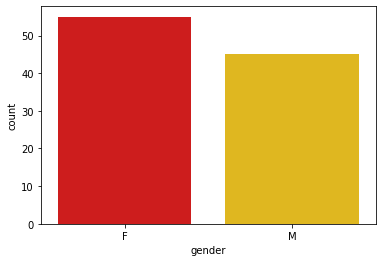

In [75]:
sns.countplot(patient_data['gender'], palette="hot")
plt.show()

## Data pre-processing#

Checklist

    1. Extract hadm_id, subject_id_ admittime, dischtime, icd9_code, description_of_code (long_title) and create new table
    2. Map the subject_id with the hadm_id and the admittime to match a patient to specific visits
    3. Map the hadm_id to each icd9_code assigned during the visit
    4. Add each code assigned to the patient directing into the dictionary with the patient-admission id mapping and the visit date mapping . Which allows us to have a list of list of icd9_code's that each patient recieved during each visit

## Training

In [50]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 10
NUM_EPOCHS = 1
NUM_WORKERS = 0